In [1]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.selectors import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# Predictions on synthetic data

In [5]:
from helpers.ann_tools import import_ANN
def predict(x, FGR=3, EXP='EXP1'):
    ann_Tall = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR{FGR}/{EXP}/model/Tall.nc')
    return ann_Tall(x).data

In [110]:
import torch
x = torch.randn(10000,27)
x = x / torch.norm(x,dim=1,keepdim=True)

In [111]:
pred = {}
for FGR in [1,2,3,4]:
    for EXP in ['EXP1', 'EXP2']:
        pred[f'FGR{FGR}-{EXP}'] = predict(x, FGR=FGR, EXP=EXP)

tensor([0.4734, 0.7596, 0.5491])

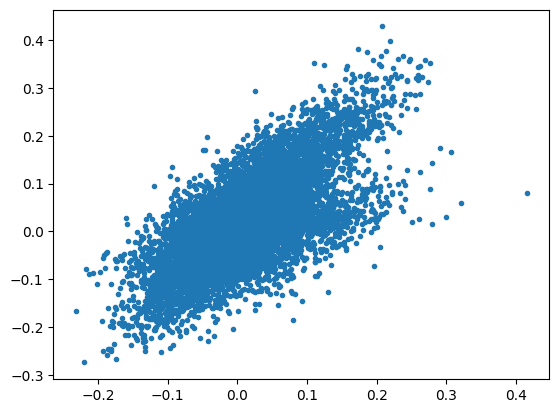

In [150]:
plt.plot(pred['FGR3-EXP1'][:,0], pred['FGR3-EXP2'][:,0],'.')
R2(pred['FGR3-EXP1'], pred['FGR3-EXP2'])

## Noise during training does not help to keep similar predictions on synthetic data

tensor([0.4572])

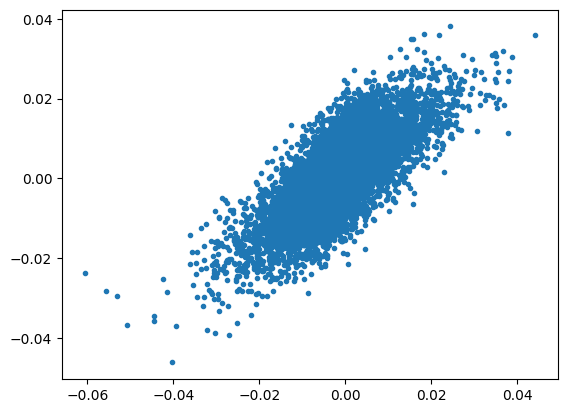

In [153]:
ann_Txy_exp1 = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/staggered-20/perturbed/EXP1/model/Txy.nc')
ann_Txy_exp2 = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/staggered-20/perturbed/EXP2/model/Txy.nc')
plt.plot(ann_Txy_exp1(x).data, ann_Txy_exp2(x).data, '.')
R2(ann_Txy_exp1(x).data, ann_Txy_exp2(x).data)

In [146]:
def R2(x,y):
    return 1 - ((x-y)**2).mean(0) / ((y**2).mean(0) - (y.mean(0))**2)

In [2]:
from helpers.cm26 import *

In [3]:
ds = read_datasets(['test'], [4], FGR=2)['test-4']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/subfilter/FGR2/factor-4


Correlation: 0.973002345348107
Relative Error: 0.5486547927282593
R2 =  0.7447556766390053
R2 max =  0.9462734933757506
Optinal scaling: 1.856924770029553
Nans [test/control]: [8479, 8479]


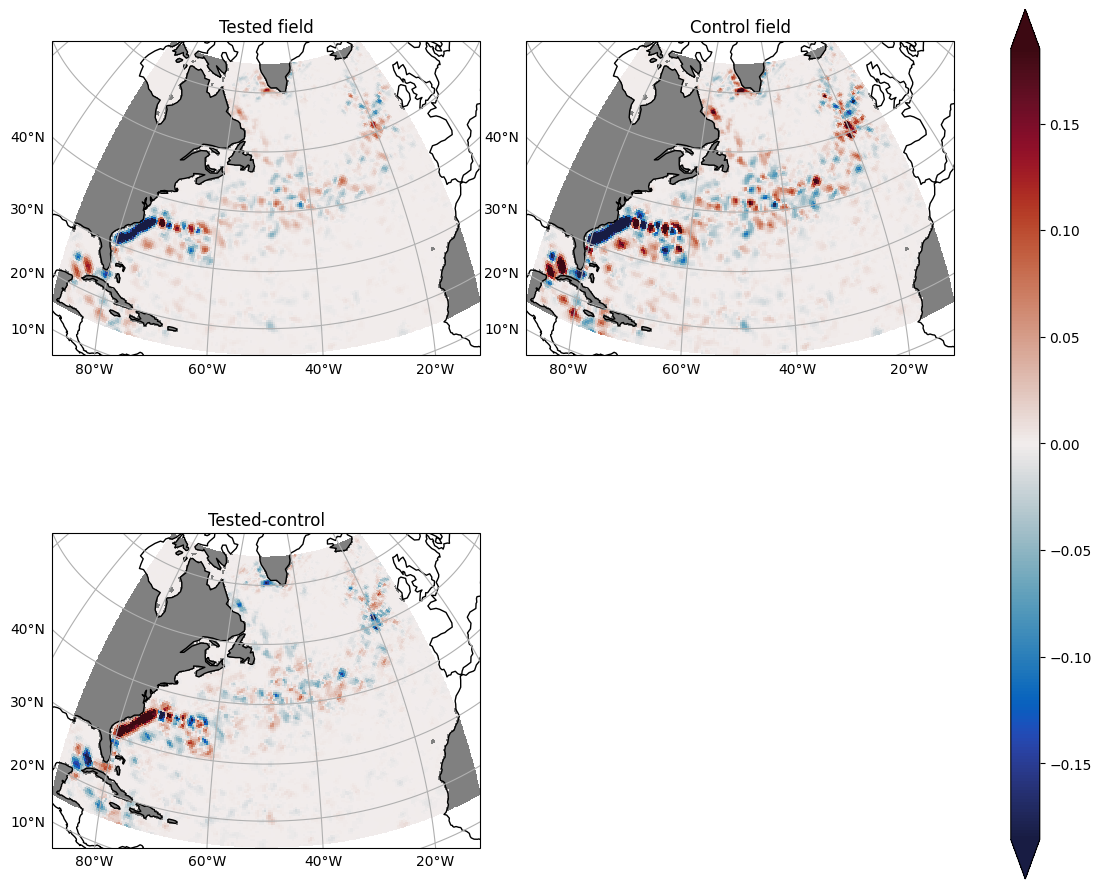

In [30]:
ds2d = ds.select2d(zl=0)
ann_Tall_exp1 = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc')
ann_Tall_exp2 = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR4/EXP1/model/Tall.nc')
pred_exp1 = ds2d.state.ANN(None,None,ann_Tall_exp1)
pred_exp2 = ds2d.state.ANN(None,None,ann_Tall_exp2)
compare(ds2d.nanvar(pred_exp1['Txy']), ds2d.nanvar(pred_exp2['Txy']), selector=select_NA)

In [147]:
R2(pred_exp2['feature_statistics']['targets'], pred_exp1['feature_statistics']['targets'])

tensor([0.7784, 0.9020, 0.8760])

# Scale-similarity on real data

In [35]:
ds = read_datasets(['test'], [4], FGR=2)['test-4']
ds2d = ds.select2d(zl=1)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/subfilter/FGR2/factor-4


In [52]:
pred = {}
pred_subgrid = {}
for FGR in [1,2,3,4]:
    ann_Tall = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR{FGR}/EXP1/model/Tall.nc')
    pred[FGR] = ds2d.state.ANN(None,None,ann_Tall)
    ann_Tall = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subgrid/FGR{FGR}/EXP1/model/Tall.nc')
    pred_subgrid[FGR] = ds2d.state.ANN(None,None,ann_Tall)

ann_Txy = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subgrid/FGR-1/EXP1/model/Txy.nc')
ann_Txx_Tyy = import_ANN(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subgrid/FGR-1/EXP1/model/Txx_Tyy.nc')
pred_subgrid[-1] = ds2d.state.ANN(ann_Txy, ann_Txx_Tyy)

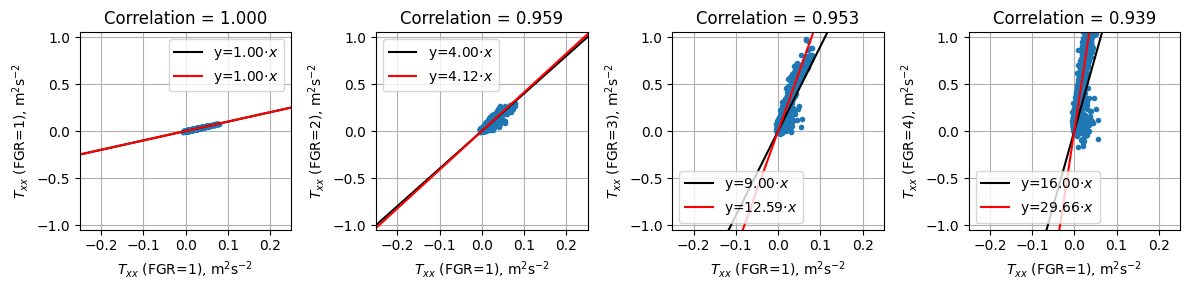

In [37]:
plt.figure(figsize=(12,3))
for col, FGR in enumerate([1,2,3,4]):
    plt.subplot(1,4,col+1)
    x = -ds2d.nanvar(pred[1]['Txx']).data.ravel()
    y = -ds2d.nanvar(pred[FGR]['Txx']).data.ravel()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    coef = (y*x).mean() / (x*x).mean()
    plt.plot(x,y,'.')
    plt.xlabel('$T_{xx}$ (FGR=1), m$^2$s$^{-2}$')
    plt.ylabel('$T_{xx}$ ' + f'(FGR={FGR}),' + ' m$^2$s$^{-2}$')
    plt.plot([-1,1], [-FGR**2,FGR**2],label='y=%.2f$\cdot x$' % (FGR**2), color='k')
    plt.plot([-1,1], [-coef,coef],label='y=%.2f$\cdot x$'%coef, color='r')
    plt.legend()
    
    plt.grid()
    plt.xlim([-0.25,0.25])
    plt.ylim([-1.05,1.05])
    plt.title(f'Correlation = %.3f' % np.corrcoef(x,y)[0,1])

plt.tight_layout()

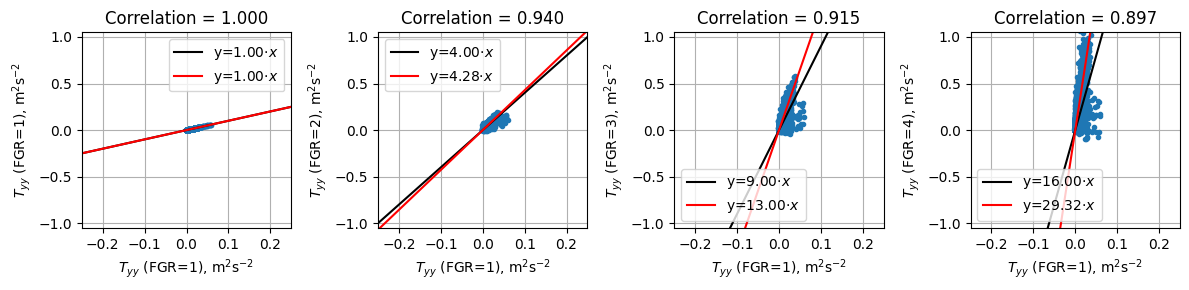

In [38]:
plt.figure(figsize=(12,3))
for col, FGR in enumerate([1,2,3,4]):
    plt.subplot(1,4,col+1)
    x = -ds2d.nanvar(pred[1]['Tyy']).data.ravel()
    y = -ds2d.nanvar(pred[FGR]['Tyy']).data.ravel()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    coef = (y*x).mean() / (x*x).mean()
    plt.plot(x,y,'.')
    plt.xlabel('$T_{yy}$ (FGR=1), m$^2$s$^{-2}$')
    plt.ylabel('$T_{yy}$ ' + f'(FGR={FGR}),' + ' m$^2$s$^{-2}$')
    plt.plot([-1,1], [-FGR**2,FGR**2],label='y=%.2f$\cdot x$' % (FGR**2), color='k')
    plt.plot([-1,1], [-coef,coef],label='y=%.2f$\cdot x$'%coef, color='r')
    plt.legend()
    
    plt.grid()
    plt.xlim([-0.25,0.25])
    plt.ylim([-1.05,1.05])
    plt.title(f'Correlation = %.3f' % np.corrcoef(x,y)[0,1])

plt.tight_layout()

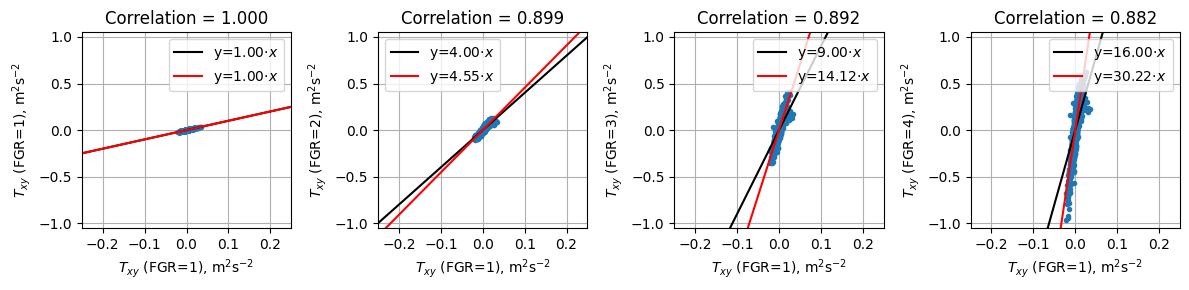

In [39]:
plt.figure(figsize=(12,3))
for col, FGR in enumerate([1,2,3,4]):
    plt.subplot(1,4,col+1)
    x = -ds2d.nanvar(pred[1]['Txy']).data.ravel()
    y = -ds2d.nanvar(pred[FGR]['Txy']).data.ravel()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    coef = (y*x).mean() / (x*x).mean()
    plt.plot(x,y,'.')
    plt.xlabel('$T_{xy}$ (FGR=1), m$^2$s$^{-2}$')
    plt.ylabel('$T_{xy}$ ' + f'(FGR={FGR}),' + ' m$^2$s$^{-2}$')
    plt.plot([-1,1], [-FGR**2,FGR**2],label='y=%.2f$\cdot x$' % (FGR**2), color='k')
    plt.plot([-1,1], [-coef,coef],label='y=%.2f$\cdot x$'%coef, color='r')
    plt.legend()
    
    plt.grid()
    plt.xlim([-0.25,0.25])
    plt.ylim([-1.05,1.05])
    plt.title(f'Correlation = %.3f' % np.corrcoef(x,y)[0,1])

plt.tight_layout()

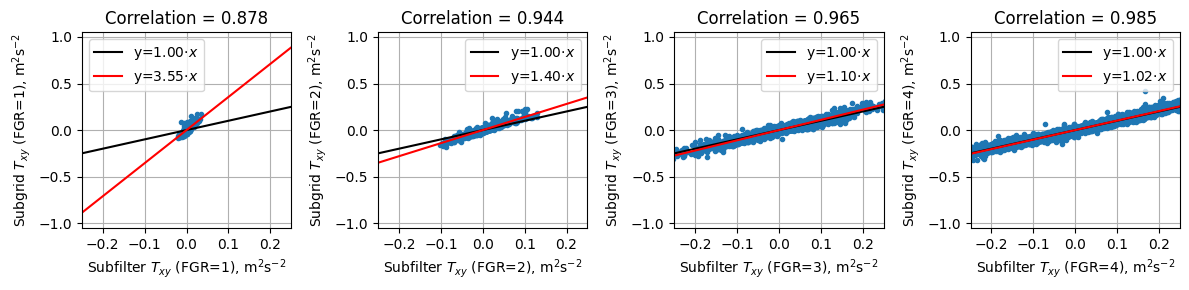

In [41]:
plt.figure(figsize=(12,3))
for col, FGR in enumerate([1,2,3,4]):
    plt.subplot(1,4,col+1)
    x = -ds2d.nanvar(pred[FGR]['Txy']).data.ravel()
    y = -ds2d.nanvar(pred_subgrid[FGR]['Txy']).data.ravel()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    coef = (y*x).mean() / (x*x).mean()
    plt.plot(x,y,'.')
    plt.xlabel('Subfilter $T_{xy}$ ' + f'(FGR={FGR}),' + ' m$^2$s$^{-2}$')
    plt.ylabel('Subgrid $T_{xy}$ ' + f'(FGR={FGR}),' + ' m$^2$s$^{-2}$')
    plt.plot([-1,1], [-1,1],label='y=%.2f$\cdot x$' % (1), color='k')
    plt.plot([-1,1], [-coef,coef],label='y=%.2f$\cdot x$'%coef, color='r')
    plt.legend()
    
    plt.grid()
    plt.xlim([-0.25,0.25])
    plt.ylim([-1.05,1.05])
    plt.title(f'Correlation = %.3f' % np.corrcoef(x,y)[0,1])

plt.tight_layout()

Text(0.5, 1.0, 'Correlation = 0.874')

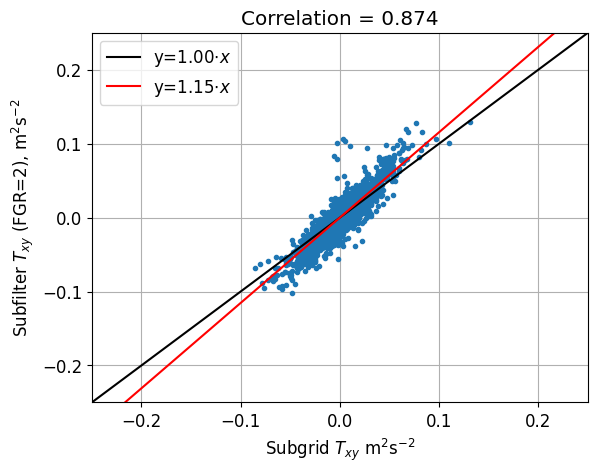

In [58]:
y = -ds2d.nanvar(pred[2]['Txy']).data.ravel()
x = -ds2d.nanvar(pred_subgrid[-1]['Txy']).data.ravel()
x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
coef = (y*x).mean() / (x*x).mean()
plt.plot(x,y,'.')
plt.ylabel('Subfilter $T_{xy}$ ' + f'(FGR={2}),' + ' m$^2$s$^{-2}$')
plt.xlabel('Subgrid $T_{xy}$' + ' m$^2$s$^{-2}$')
plt.plot([-1,1], [-1,1],label='y=%.2f$\cdot x$' % (1), color='k')
plt.plot([-1,1], [-coef,coef],label='y=%.2f$\cdot x$'%coef, color='r')
plt.legend()

plt.grid()
plt.xlim([-0.25,0.25])
plt.ylim([-0.25,0.25])
plt.title(f'Correlation = %.3f' % np.corrcoef(x,y)[0,1])

# Subfilter and subgrid energy transfer

In [44]:
def read_skill(exp='EXP0', factors=[4,9,12,15], base_path='/scratch/pp2681/mom6/CM26_ML_models/ocean3d'):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'{base_path}/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [45]:
def backscatter_ratio(transfer, freq_str):
    transfer_noncompensated = transfer / transfer[freq_str]
    transfer_plus = np.maximum(transfer_noncompensated,0.0)
    transfer_minus =  np.minimum(transfer_noncompensated,0.0)
    return -transfer_plus.sum(freq_str) / transfer_minus.sum(freq_str)

In [46]:
def plot_transfer(transfer, freq_str='freq_r_NA', zl=0, color='tab:blue'):
    mean = transfer.mean('time').isel(zl=zl)
    std = transfer.std('time').isel(zl=zl)
    
    mean.plot(xscale='log',color=color,lw=2)
    plt.fill_between(mean[freq_str],mean-std,mean+std,alpha=0.05,color=color, linewidth=0)
    return backscatter_ratio(mean,freq_str)

In [47]:
def plot_transfer_4_regions(exps_name = ['subfilter/FGR1/EXP1'], zl=5,factor=4, labels=[]):
    plt.figure(figsize=(10,8))
    plt.rcParams['font.size']=12

    colors= ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']

    exps = []
    for exp in exps_name:
        exps.append(read_skill(exp))
        
    plt.subplot(2,2,1)
    
    for exp, color in zip(exps, colors):
        plot_transfer(exp[factor].transfer_NA,'freq_r_NA',zl=zl,color=color)
    
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('North Atlantic')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(22.6e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])

    plt.subplot(2,2,2)

    for exp, color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_Pacific,'freq_r_Pacific',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    
    plt.title('Pacific')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(28.5e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    
    plt.subplot(2,2,3)
    
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ACC,'freq_r_ACC',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('ACC')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(10.5e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
        
    plt.subplot(2,2,4)

    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_Equator,'freq_r_Equator',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Equator')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.tight_layout()
    plt.axvline(x=1/(89.9e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    
    for label, color in zip(labels,colors):
        plt.plot(np.nan,np.nan,color=color,label=label)
    plt.plot(np.nan,np.nan,color='gray',ls='--',label='$1/R_d$')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.suptitle(f'Coarsegraining factor: {factor}, Depth: %.0f m' % (float(-exp[factor].zl[zl])), y=1.03)

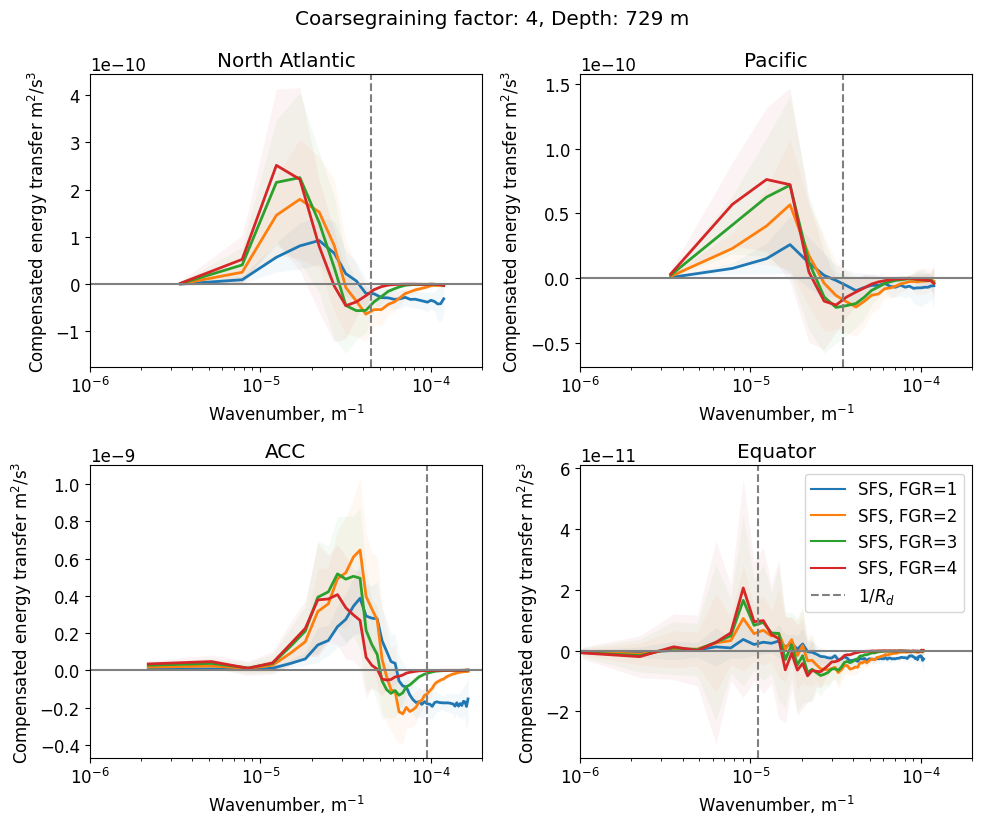

In [266]:
plot_transfer_4_regions(['subfilter/FGR1/EXP1', 'subfilter/FGR2/EXP1', 'subfilter/FGR3/EXP1', 'subfilter/FGR4/EXP1'], 
                        labels=['SFS, FGR=1', 'SFS, FGR=2', 'SFS, FGR=3', 'SFS, FGR=4'])

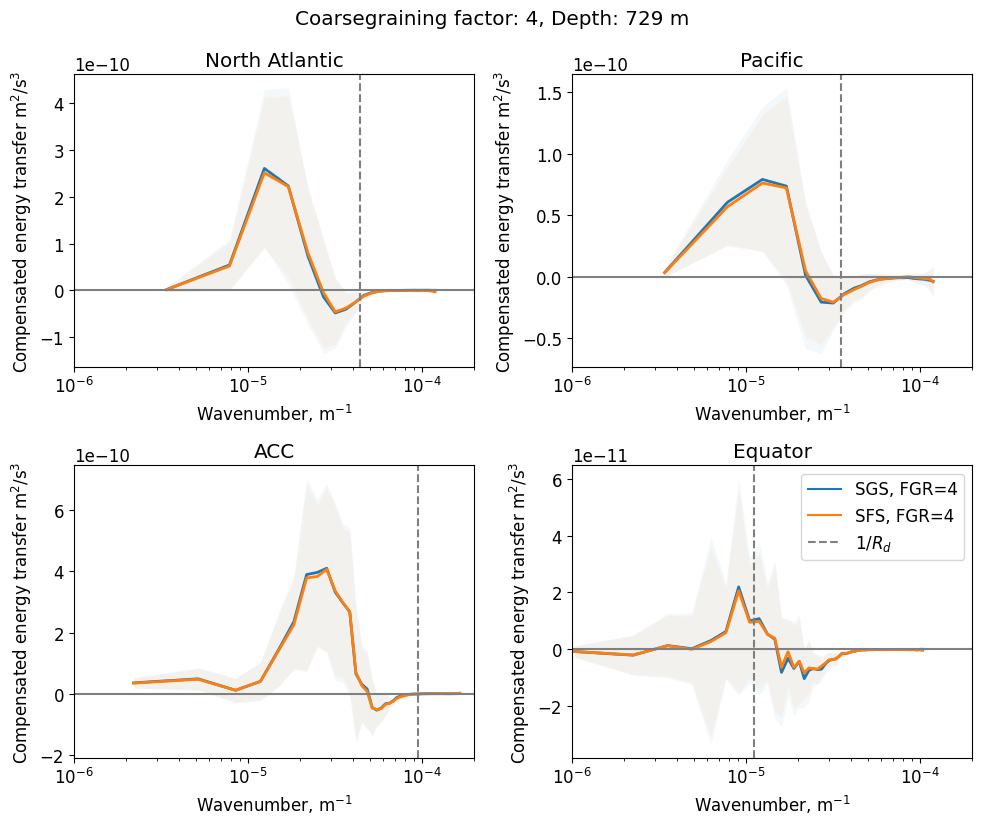

In [274]:
plot_transfer_4_regions(['subgrid/FGR4/EXP1', 'subfilter/FGR4/EXP1'], 
                        labels=['SGS, FGR=4', 'SFS, FGR=4'])

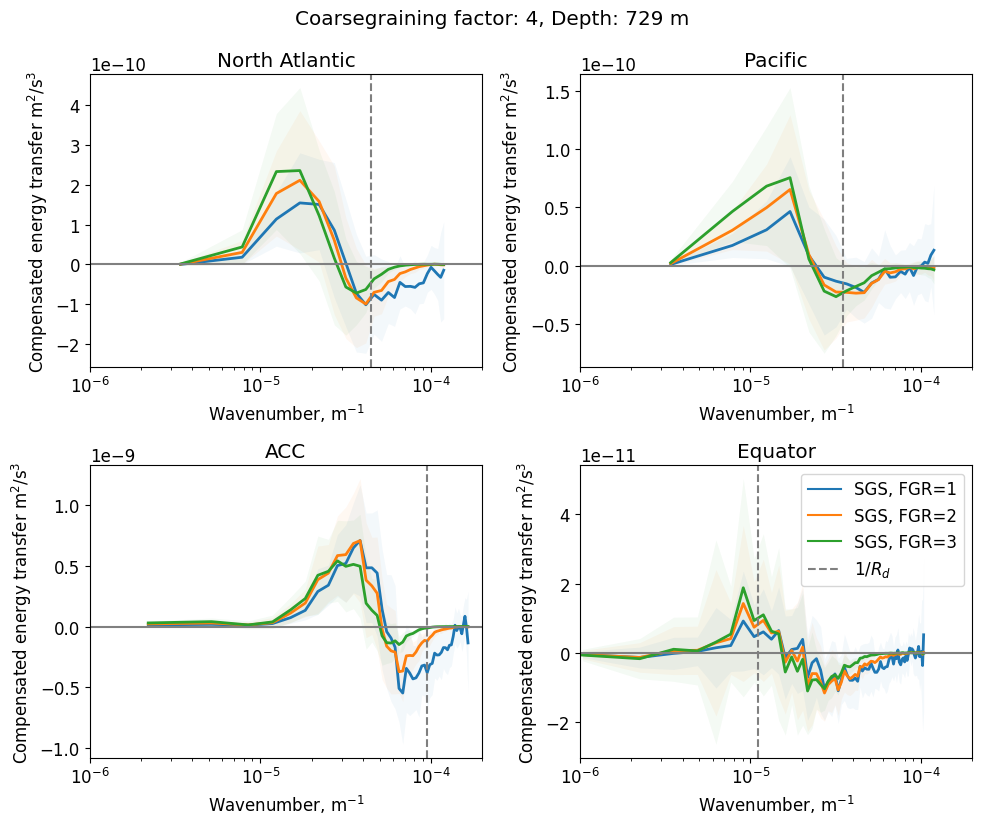

In [62]:
plot_transfer_4_regions(['subgrid/FGR1/EXP1', 'subgrid/FGR2/EXP1', 'subgrid/FGR3/EXP1'], 
                        labels=['SGS, FGR=1', 'SGS, FGR=2', 'SGS, FGR=3'])

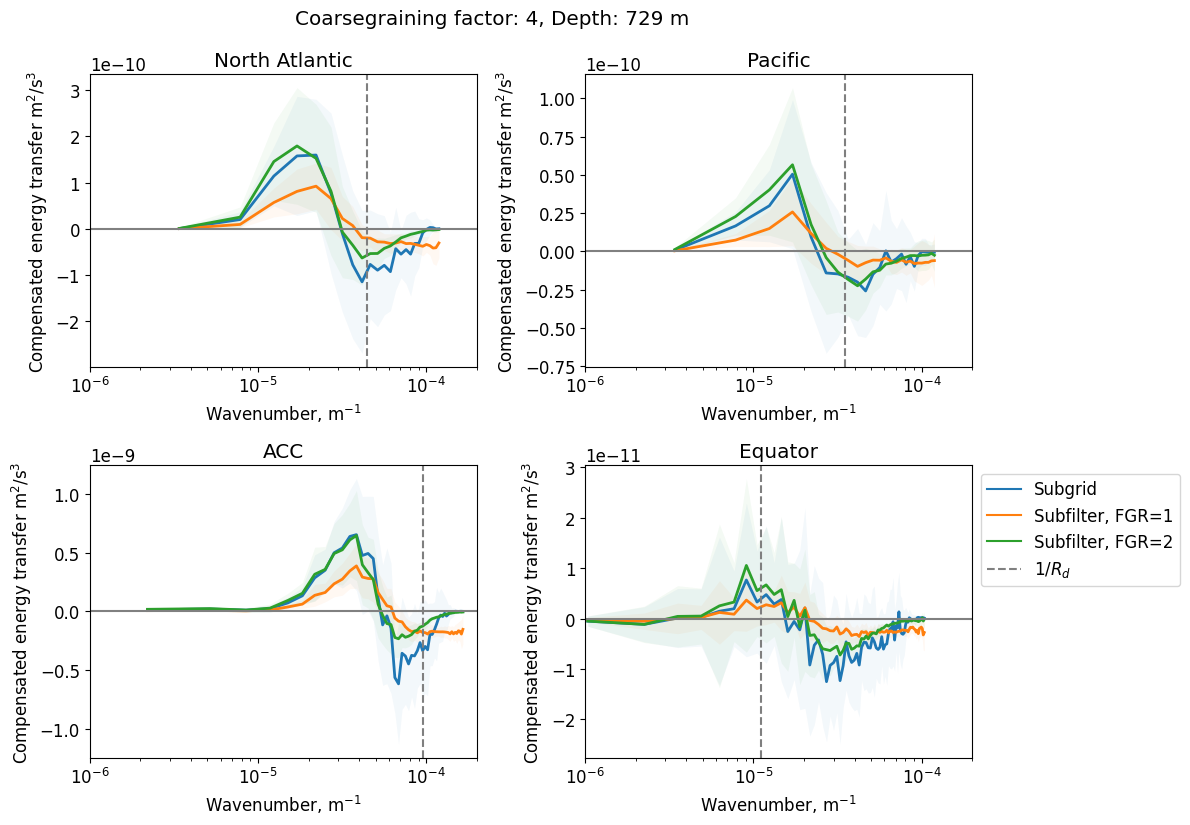

In [59]:
plot_transfer_4_regions(['subgrid/FGR-1/EXP1','subfilter/FGR1/EXP1', 'subfilter/FGR2/EXP1'], 
                        labels=['Subgrid', 'Subfilter, FGR=1', 'Subfilter, FGR=2'])